In [18]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.signal import square
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Simulation

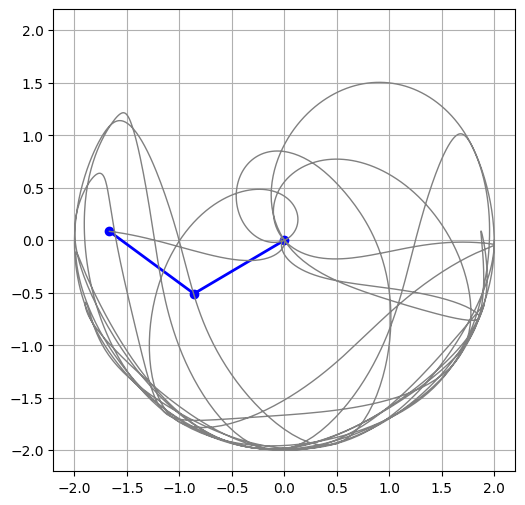

In [15]:

# Parameters
g = 9.81
L1 = 1.0
L2 = 1.0
m1 = 1.0
m2 = 1.0

# Rectangular torque signal
def torque_input(t):
    freq = 0.25  # Hz
    amplitude = 1.0  # N.m
    return amplitude * square(2 * np.pi * freq * t)

# Double pendulum dynamics
def double_pendulum(t, y):
    theta1, omega1, theta2, omega2 = y
    delta = theta2 - theta1
    tau = torque_input(t)

    den1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta)**2
    den2 = (L2 / L1) * den1

    domega1 = (
        m2 * L1 * omega1**2 * np.sin(delta) * np.cos(delta) +
        m2 * g * np.sin(theta2) * np.cos(delta) +
        m2 * L2 * omega2**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta1) +
        tau
    ) / den1

    domega2 = (
        -m2 * L2 * omega2**2 * np.sin(delta) * np.cos(delta) +
        (m1 + m2) * g * np.sin(theta1) * np.cos(delta) -
        (m1 + m2) * L1 * omega1**2 * np.sin(delta) -
        (m1 + m2) * g * np.sin(theta2)
    ) / den2

    return [omega1, domega1, omega2, domega2]

# Initial conditions
y0 = [np.pi / 2, 0, np.pi / 2, 0]
t_span = (0, 20)
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Solve
sol = solve_ivp(double_pendulum, t_span, y0, t_eval=t_eval, rtol=1e-8)
theta1, omega1, theta2, omega2 = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

# Coordinates
x1 = L1 * np.sin(theta1)
y1 = -L1 * np.cos(theta1)
x2 = x1 + L2 * np.sin(theta2)
y2 = y1 - L2 * np.cos(theta2)

# Plot animation
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2, color='blue')
trace, = ax.plot([], [], '-', lw=1, color='gray')
history_x, history_y = [], []

def init():
    line.set_data([], [])
    trace.set_data([], [])
    return line, trace

def update(frame):
    thisx = [0, x1[frame], x2[frame]]
    thisy = [0, y1[frame], y2[frame]]
    line.set_data(thisx, thisy)

    history_x.append(x2[frame])
    history_y.append(y2[frame])
    trace.set_data(history_x, history_y)
    return line, trace

ani = animation.FuncAnimation(fig, update, frames=len(t_eval),
                              init_func=init, blit=True, interval=20)

# Display in Colab
HTML(ani.to_html5_video())



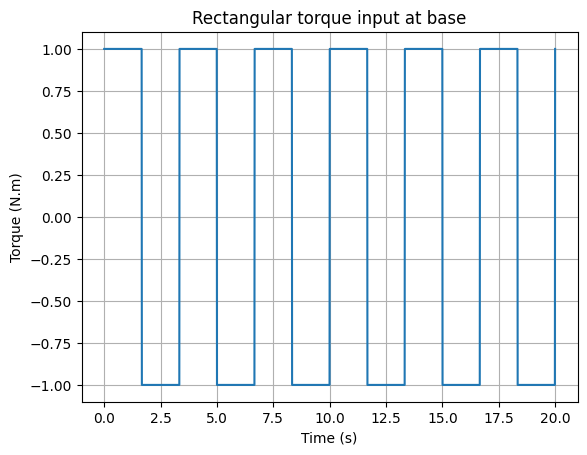

In [13]:
plt.figure()
torque_t = [torque_input(t) for t in t_eval]
plt.plot(t_eval, torque_t)
plt.title("Rectangular torque input at base")
plt.xlabel("Time (s)")
plt.ylabel("Torque (N.m)")
plt.grid()
plt.show()


# MLP Data Preprocessing

In [16]:

# For time step 1 to N-1:
X = np.column_stack((
    torque_t[1:],          # torque at t
    theta1[:-1], omega1[:-1],   # previous theta1, omega1
    theta2[:-1], omega2[:-1]    # previous theta2, omega2
))

Y = np.column_stack((
    theta1[1:], omega1[1:],
    theta2[1:], omega2[1:]
))

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]


scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

X_test_scaled = scaler_X.transform(X_test)
Y_test_scaled = scaler_Y.transform(Y_test)


# MLP model training

In [36]:

# Convert your data to torch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_torch = torch.tensor(Y_test_scaled, dtype=torch.float32)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_size=5, hidden_size=128, output_size=4):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Instantiate model
model = MLP()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)




Epoch [10/200], Loss: 0.995467
Epoch [20/200], Loss: 0.995192
Epoch [30/200], Loss: 0.995025
Epoch [40/200], Loss: 0.994809
Epoch [50/200], Loss: 0.980195
Epoch [60/200], Loss: 0.996804
Epoch [70/200], Loss: 0.995144
Epoch [80/200], Loss: 0.994878
Epoch [90/200], Loss: 0.994355
Epoch [100/200], Loss: 0.996500
Epoch [110/200], Loss: 0.995189
Epoch [120/200], Loss: 0.994912
Epoch [130/200], Loss: 0.994698
Epoch [140/200], Loss: 0.993378
Epoch [150/200], Loss: 0.994173
Epoch [160/200], Loss: 0.995466
Epoch [170/200], Loss: 0.994989
Epoch [180/200], Loss: 0.994770
Epoch [190/200], Loss: 0.998215
Epoch [200/200], Loss: 0.995586


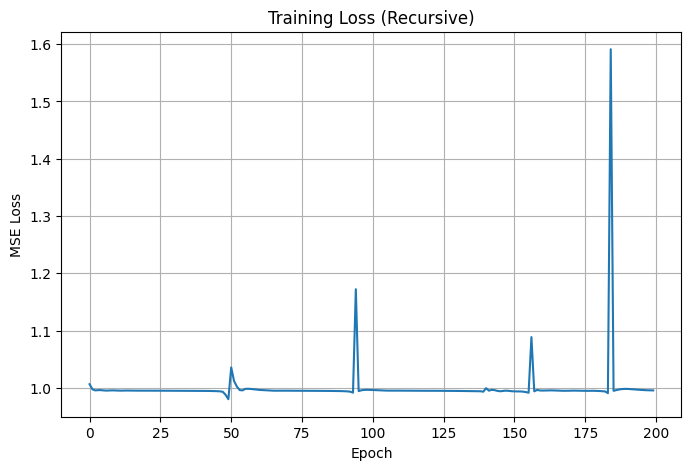

In [37]:
num_epochs = 200
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Initialize the first input (t=0)
    X_rec = X_train_scaled[0].copy().reshape(1, -1)

    preds_scaled = []

    for t in range(len(X_train_scaled)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)

        Y_pred_scaled = model(X_rec_torch)
        preds_scaled.append(Y_pred_scaled)

        if t < len(X_train_scaled) - 1:
            # Next torque input
            next_torque = X_train_scaled[t + 1, 0].reshape(1, 1)
            # Build next input: next torque + current prediction
            Y_pred_np = Y_pred_scaled.detach().numpy()
            X_rec = np.concatenate([next_torque, Y_pred_np], axis=1)

    # Stack predictions
    preds_scaled = torch.cat(preds_scaled, dim=0)

    # True outputs
    Y_train_torch_seq = torch.tensor(Y_train_scaled, dtype=torch.float32)

    # Compute loss
    loss = criterion(preds_scaled, Y_train_torch_seq)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Plot training loss
plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss (Recursive)')
plt.grid(True)
plt.show()


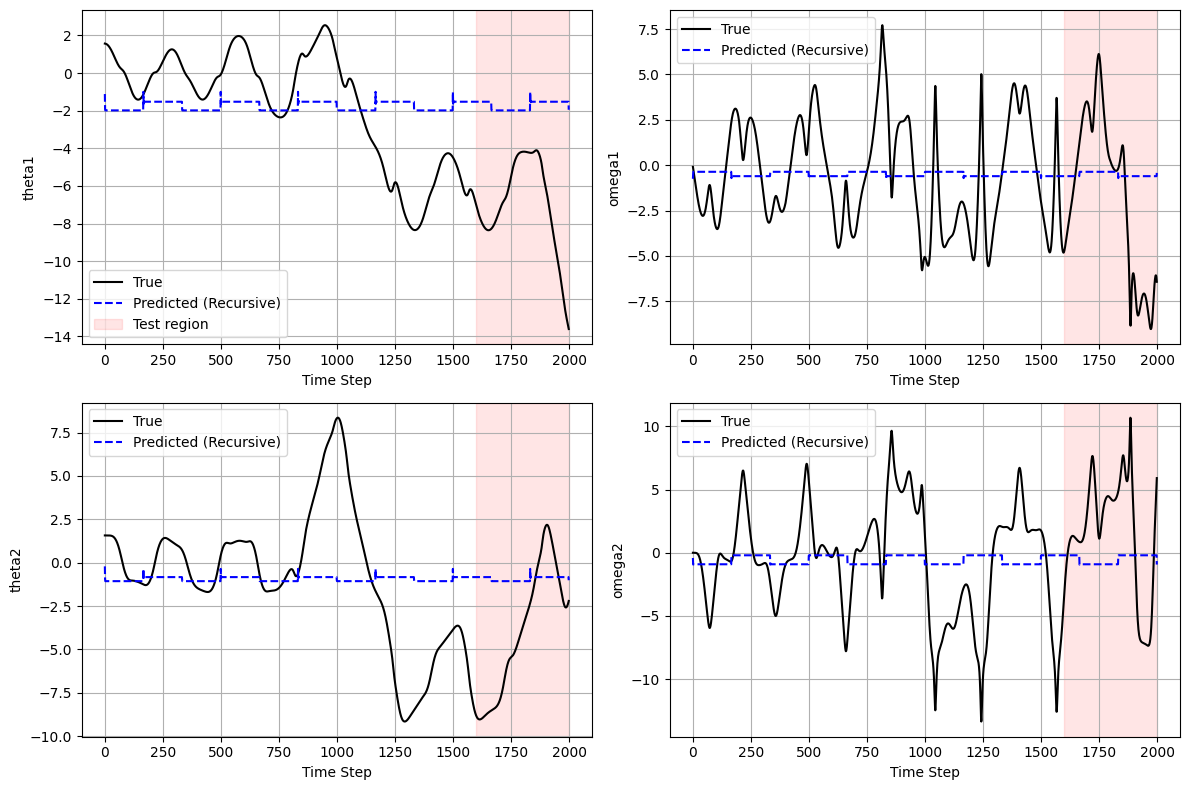

In [38]:

# Combine train and test scaled data for full sequence
X_scaled_all = np.vstack([X_train_scaled, X_test_scaled])
Y_scaled_all = np.vstack([Y_train_scaled, Y_test_scaled])

# Alternatively (cleaner): scale entire X and Y directly for this purpose
# This avoids any potential mismatch from separate scaling
#X_scaled_all = scaler_X.transform(X)
#Y_scaled_all = scaler_Y.transform(Y)

# We will now predict recursively from t=0
X_rec = X_scaled_all[0].copy().reshape(1, -1)

Y_preds_scaled = []

model.eval()
with torch.no_grad():
    for t in range(len(X_scaled_all)):
        X_rec_torch = torch.tensor(X_rec, dtype=torch.float32)
        Y_pred_scaled = model(X_rec_torch).numpy().flatten()

        Y_preds_scaled.append(Y_pred_scaled)

        if t < len(X_scaled_all) - 1:
            # Get true torque at t+1
            next_torque = X_scaled_all[t + 1, 0].reshape(1, 1)  # torque
            # Build next input: torque + predicted state
            next_input = np.concatenate([next_torque, Y_pred_scaled.reshape(1, -1)], axis=1)
            X_rec = next_input

# Convert list to array
Y_preds_scaled = np.array(Y_preds_scaled)

# Inverse scale
Y_preds = scaler_Y.inverse_transform(Y_preds_scaled)
Y_true = scaler_Y.inverse_transform(Y_scaled_all)

# Plot
plt.figure(figsize=(12, 8))
labels = ['theta1', 'omega1', 'theta2', 'omega2']
time_all = np.arange(len(Y_true))

for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.plot(time_all, Y_true[:, i], label='True', color='black')
    plt.plot(time_all, Y_preds[:, i], '--', label='Predicted (Recursive)', color='blue')

    plt.axvspan(split_idx, len(Y_true)-1, color='red', alpha=0.1, label='Test region' if i == 0 else None)

    plt.xlabel('Time Step')
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
